In [1]:
import numpy as np
import pandas as pd
import pathlib
from scipy import sparse
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay,\
                                                                                        accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
import time
from sklearn.naive_bayes import MultinomialNB

### Loading Data

In [2]:
datapath = pathlib.Path('..') / 'Data'
data_loader = np.load(datapath / 'PreprocessedData.npz')
X_train = sparse.csr_matrix((data_loader['X_train_data'],
                             data_loader['X_train_indices'],
                             data_loader['X_train_indptr']),
                            shape = data_loader['X_train_shape'])
y_train = data_loader['y_train']
X_test = sparse.csr_matrix((data_loader['X_test_data'],
                            data_loader['X_test_indices'],
                            data_loader['X_test_indptr']),
                           shape = data_loader['X_test_shape'])
y_test = data_loader['y_test']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(34696, 35003) (34696,) (6123, 35003) (6123,)


### Model

In [3]:
def test_results(y_test, y_pred):
    '''
        Print out various validation results
        takes actual and predicted labels of test set as input
        Prints out the numbers, no return value
        Also prints time taken from global variables used
    '''
    precision, recall, fscore, train_support = score(y_test, y_pred,
                                                 labels = ['Real', 'Fake'], average='binary')
    print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        round(fit_time, 3), round(pred_time, 3), round(precision, 3),
        round(recall, 3), round((y_pred == y_test).sum()/len(y_pred), 3)))
    
    print('\nClassification Report :\n')
    print(classification_report(y_test, y_pred, target_names = ['Real', 'Fake']))

    print('ROC AUC Score : {}\n'.format(roc_auc_score(y_test, y_pred)))
    
    print('\nConfusion Matrix :\n')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels = [0, 1],
                                            display_labels = ['Real', 'Fake'], cmap = 'magma')

In [4]:
print('Default Parameters of MultinomialNB :\n{}'.format(MultinomialNB().get_params()))

Default Parameters of MultinomialNB :
{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}


Fit time: 0.017 / Predict time: 0.002 ---- Precision: 0.91 / Recall: 0.972 / Accuracy: 0.941

Classification Report :

              precision    recall  f1-score   support

        Real       0.97      0.91      0.94      3187
        Fake       0.91      0.97      0.94      2936

    accuracy                           0.94      6123
   macro avg       0.94      0.94      0.94      6123
weighted avg       0.94      0.94      0.94      6123

ROC AUC Score : 0.94195007562227


Confusion Matrix :



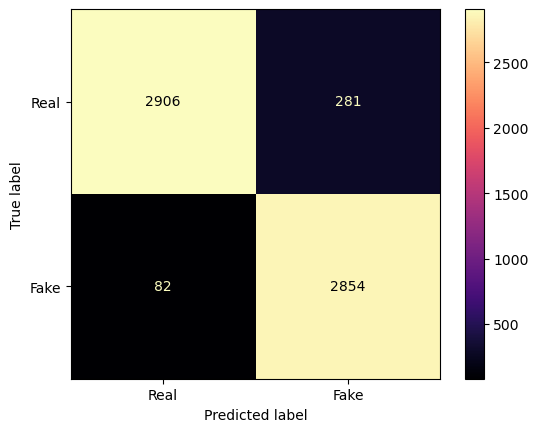

In [5]:
nb = MultinomialNB()

start = time.time()
nb_model = nb.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = nb_model.predict(X_test)
end = time.time()
pred_time = (end - start)

test_results(y_test, y_pred)

I'll treat this score as baseline. Usually most basic algorithm is selected as baseline - but it can be anything that you consider your starting point. I think Naive Bayes is simple enough to understand, so it can be a good candidate for a baseline model. Also, since I literally started this project with MultinomialNB (https://www.kaggle.com/code/koustavin/94-acc-multinomialnb-with-diff-vectorizers) - it makes sense for me to use it as baseline and try to improve the score from there.

### Another Look at The Results

In [6]:
tweets_train = pd.read_csv(datapath / 'X_train.csv')
tweets_test = pd.read_csv(datapath / 'X_test.csv')

In [8]:
tweets_test['y_pred'] = y_pred
tweets_test['y_test'] = y_test
tweets_test[tweets_test.y_pred != tweets_test.y_test]

,tweet,tokens,len,tok_pct,stp_pct,tok_cnt,len_bcx,len_bcx_scaled,tok_pct_scaled,stp_pct_scaled,rejoined_tokens,y_pred,y_test
7,"senegal has so far played a big match, and bec...","['senegal', 'far', 'played', 'big', 'match', '...",143,61.538462,20.279720,16,18.441959,0.458929,0.613271,0.310956,senegal far played big match beckford saved ea...,1,0
18,al-ahly leads aswan 2/1 ahmed khaled leads asw...,"['al', 'ahly', 'lead', 'aswan', '2', '1', 'ahm...",135,74.814815,8.148148,21,17.914673,0.445202,0.746764,0.124938,al ahly lead aswan 2 1 ahmed khaled lead aswan...,0,1
36,we don't want to use the public as a pressure ...,"['want', 'use', 'public', 'pressure', 'card']",49,51.020408,20.408163,5,10.552785,0.253552,0.507513,0.312925,want use public pressure card,1,0
46,news on the go\n falls to _ tunisian in the a...,"['news', 'go', 'fall', 'tunisian', 'african', ...",72,62.500000,16.666667,7,12.962709,0.316289,0.622940,0.255556,news go fall tunisian african handball champio...,0,1
47,ghaly's victory makes zamalek singly sing in f...,"['ghaly', 'victory', 'make', 'zamalek', 'singl...",88,71.590909,9.090909,12,14.394492,0.353562,0.714348,0.139394,ghaly victory make zamalek singly sing fourth ...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,hassan al-mestekawi: al-ahly was the best team...,"['hassan', 'al', 'mestekawi', 'al', 'ahly', 'b...",74,62.162162,21.621622,9,13.150682,0.321182,0.619543,0.331532,hassan al mestekawi al ahly best team beginnin...,1,0
6087,and who doesn't like the preacher!!???,"['like', 'preacher']",32,37.500000,28.125000,2,8.327973,0.195634,0.371566,0.431250,like preacher,1,0
6102,martin jol calls on al-ahly players to take re...,"['martin', 'jol', 'call', 'al', 'ahly', 'playe...",60,70.000000,10.000000,9,11.769062,0.285215,0.698352,0.153333,martin jol call al ahly player take revenge sm...,1,0
6103,happy friday everyone,"['happy', 'friday', 'everyone']",21,90.476190,0.000000,3,6.509532,0.148294,0.904239,0.000000,happy friday everyone,1,0


In [11]:
# False Positives / Type I Errors
tweets_test.loc[((tweets_test.y_pred == 1) & (tweets_test.y_test == 0)), 'tweet'].values

array(['senegal has so far played a big match, and beckford saved an early goal opportunity. the teranga lions are able to score against the english goal',
       "we don't want to use the public as a pressure card",
       "ghaly's victory makes zamalek singly sing in fourth place, away from smouha, by four points.",
       "journalist medhat shalaby's page extends condolences to journalist ahmed owais on the death of his mother, may god have mercy on her and may god forgive her for her sins.\nahmed awes",
       'muhammad al-ghazzawi: the al-ahly club has its limits, and the most important thing is that the club is above all its children',
       'which is better, from your point of view, for players to rise to the first team and participate with them, or to win the junior championship?? issue for discussion',
       'minister of aviation: we do not deny the hypothesis of a terrorist act in the missing plane accident',
       "essam abdel fattah: we didn't see who threw the ball in a

In [12]:
# False Negatives / Type II Errors
tweets_test.loc[((tweets_test.y_pred == 0) & (tweets_test.y_test == 1)), 'tweet'].values

array(['al-ahly leads aswan 2/1 ahmed khaled leads aswan, taher taher and hussam hassan score for al-ahly\neliminate the goal of electricity offside',
       'news on the go\n falls to  _ tunisian in the african handball championship',
       "moataz al-shami\nthe youth sector in al-ahly and the foreign expert\nthere is a crisis in al-ahly because of the lack of youth\nat the required level and after buying 8 juniors\nthe intention is to buy more and try to implement\nferrera's project to prepare juniors was denied\nsamson is a big headache\ninside al-ahly and its committees, it is strongly trying\nreducing the deal",
       'i have a knockout match on sunday, and i am my coach, and he took a vacation from 30/5 in their country. he finished and went to morocco for a training session. he is a coach and back on friday at night. he will lead the team for one practice, saturday, and play sunday!\nsami shirts qaim duty and increase haha',
       'i am no longer able to watch al-ahly, mohame

I don't notice anything obvious that can help reduce these False Positives / False Negatives. So, I'm not going back to preprocessing - the current dataset is final.